In [11]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
import scipy.stats as stats
import importlib
import pandas as pd

# Generate synthetic data 

In [12]:
N = 50

X = np.random.rand(N,1)*12
k1 = GPy.kern.RBF(1, variance=1, lengthscale=50)
K1 = k1.K(X)
f1 = np.random.multivariate_normal(np.zeros(N), K1).reshape(N,1)

k2 = GPy.kern.RBF(1, variance=1, lengthscale=5)
K2 = k2.K(X)
f2 = np.random.multivariate_normal(np.zeros(N), K2).reshape(N,1)

k3 = GPy.kern.RBF(1, variance=0.2, lengthscale=0.1)
K3 = k3.K(X)
f3 = np.random.multivariate_normal(np.zeros(N), K3).reshape(N,1)

f = np.hstack((f1, f2, f3))

W = np.array([[1, 0, 0], 
              [0, 1, 0], 
              [0, 0, 1]])

Y = np.dot(f,W) + np.random.randn(*f.shape) * 0.001

In [ ]:
Ntrain = 35
Xtrain = X[:Ntrain,:]
Ytrain = Y[:Ntrain,:]
Xtest = X[Ntrain:,:]
Ytest = Y[Ntrain:,:]

In [ ]:
f, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
for i in range(3):
    axes[i].plot(Xtrain, Ytrain[:,i], linestyle='', marker='o')
    axes[i].plot(Xtest, Ytest[:,i], linestyle='', marker='x')

In [ ]:
ones = np.ones(Xtest.shape[0])[:,np.newaxis]
newX = np.vstack([np.hstack([Xtest,ones*i]) for i in range(3)])
noise_dict = {'output_index': newX[:,[-1]].astype(int)}

In [ ]:
Xstar = np.linspace(0, 12, 30000)[:,None]
ones_star = np.ones(Xstar.shape[0])[:,np.newaxis]
newXstar = np.vstack([np.hstack([Xstar,ones_star*i]) for i in range(3)])
noise_dict_star = {'output_index': newXstar[:,[-1]].astype(int)}

In [ ]:
k1 = GPy.kern.RBF(1).prod(GPy.kern.Coregionalize(1, 3, active_dims=[1], rank=1, name='B'), name='k1')
k1.B.kappa.constrain_fixed(0)

k2 = GPy.kern.RBF(1).prod(GPy.kern.Coregionalize(1, 3, active_dims=[1], rank=1, name='B'), name='k2')
k2.B.kappa.constrain_fixed(0)

k3 = GPy.kern.RBF(1).prod(GPy.kern.Coregionalize(1, 3, active_dims=[1], rank=1, name='B'), name='k3')
k3.B.kappa.constrain_fixed(0)

k = k1+k2+k3
k

#k = GPy.kern.RBF(1).prod(GPy.kern.Coregionalize(1, 3, active_dims=[1], rank=3, name='B'),name='icm')

m = GPy.models.GPCoregionalizedRegression([Xtrain for i in range(3)], 
                                          [Ytrain[:,[i]] for i in range(3)],
                                           kernel=k)
#m.icm.B.kappa.constrain_fixed(0)
m.optimize()

m

In [ ]:
print(newX.shape)
mu, var = m.predict(newX, Y_metadata=noise_dict)
mu = np.reshape(mu, (3, -1)).T
mse = np.mean(np.square(mu - Ytest), axis=0)
    
print(mse)

print(newXstar.shape)
mu, var = m.predict(newXstar, Y_metadata=noise_dict_star)
mu = np.reshape(mu, (3, -1)).T
var = np.reshape(var, (3, -1)).T
a, b = stats.norm.interval(0.95, mu, np.sqrt(var))
    
f, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
for i in range(3):
    axes[i].plot(Xtrain, Ytrain[:,i], linestyle='', marker='o')
    axes[i].plot(Xtest, Ytest[:,i], linestyle='', marker='x')
    axes[i].plot(Xstar, mu[:,i])
    axes[i].fill_between(Xstar[:,0], a[:,i], b[:,i], alpha=0.2)
plt.show()

In [ ]:
import gp #import the module here, so that it can be reloaded.
importlib.reload(gp)


In [ ]:
model = gp.GPModel({})
model.train(Xtrain, Ytrain)

In [ ]:
samples = model.predict(Xstar, n_samples=10)
samples.shape

In [ ]:
f, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 5))
for i in range(3):
    for s in range(samples.shape[0]):
        axes[i].plot(Xstar, samples[s,:,i])
plt.show()

In [13]:
import numpy.random as rng

In [14]:
df = pd.read_csv("r490.csv")
df = df[df['r1_charge_heater'] >= 0]

X = np.array(df[['r1_temp', 'r2_temp', 'r1_pressure', 'r2_pressure']])
Y = np.array(df[['r1_charge_heater', 'process_ron', 'process_yield']])


In [15]:
ix = rng.permutation(X.shape[0])
N = 40

Xtrain = X[ix[:N],:]
Ytrain = Y[ix[:N],:]

In [16]:
n_inputs = X.shape[1]
n_outputs = Y.shape[1]

slfm_kernel = GPy.kern.RBF(n_inputs).prod(GPy.kern.Coregionalize(1, n_outputs, active_dims=[n_inputs], rank=1, name='B'), name='k0')
slfm_kernel.B.kappa.constrain_fixed(1)
for i in range(1,n_outputs):
    k = GPy.kern.RBF(n_inputs).prod(GPy.kern.Coregionalize(1, n_outputs, 
            active_dims=[n_inputs], rank=1, name='B'), name='k%d' % i)
    k.B.kappa.constrain_fixed(1)
    slfm_kernel = slfm_kernel + k
            
#k = GPy.kern.RBF(n_inputs).prod(GPy.kern.Coregionalize(1, n_outputs, active_dims=[n_inputs], rank=1, name='B'),name='icm')
k = GPy.util.multioutput.ICM(input_dim=n_inputs,num_outputs=n_outputs, kernel=GPy.kern.RBF(n_inputs))

m = GPy.models.GPCoregionalizedRegression([Xtrain for i in range(n_outputs)], 
                                          [Ytrain[:,[i]] for i in range(n_outputs)],
                                           kernel=k)
#m.icm.B.kappa.constrain_fixed(0)
m.optimize()

m

gp.,value,constraints,priors
ICM.rbf.variance,25843.79391607601,+ve,
ICM.rbf.lengthscale,41.94659298366811,+ve,
ICM.B.W,"(3, 1)",,
ICM.B.kappa,"(3,)",+ve,
mixed_noise.Gaussian_noise_0.variance,4330.972379281182,+ve,
mixed_noise.Gaussian_noise_1.variance,1383.1230724899988,+ve,
mixed_noise.Gaussian_noise_2.variance,5.562684646268137e-309,+ve,


In [17]:
r1ts = np.linspace(128, 166, 100)
r2ts = np.linspace(128, 166, 100)
Xstar = []
for r1t in r1ts:
    for r2t in r2ts:
        Xstar.append([r1t, r2t, 50, 50])
Xstar = np.array(Xstar)

ones = np.ones(Xstar.shape[0])[:,np.newaxis]
newX = np.vstack([np.hstack([Xstar,ones*i]) for i in range(n_outputs)])
noise_dict = {'output_index': newX[:,[-1]].astype(int)}

In [18]:
mu, var = m.predict(newX, Y_metadata=noise_dict)
mu = np.reshape(mu, (n_outputs, Xstar.shape[0])).T
var = np.reshape(var, (n_outputs, Xstar.shape[0])).T

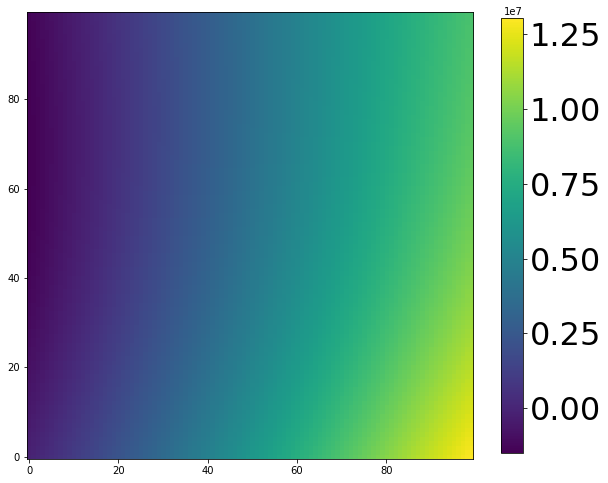

In [19]:
predicted_ch = np.reshape(mu[:,0], (100, 100))
f, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(predicted_ch, origin='lower')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=32) 

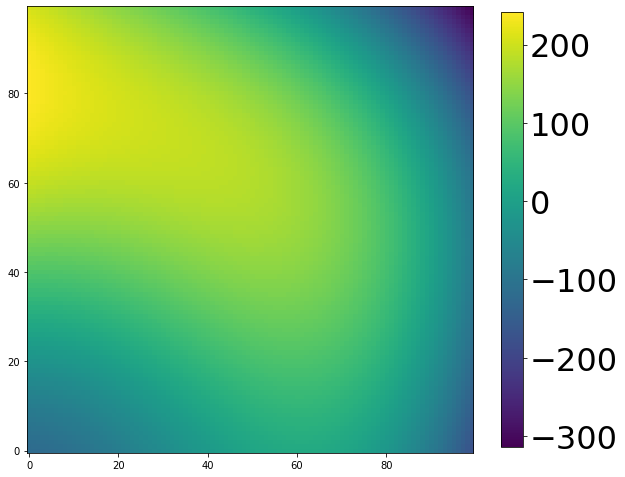

In [20]:
predicted_ron = np.reshape(mu[:,1], (100, 100))
f, ax = plt.subplots(1, 1, figsize=(10, 10))
im = ax.imshow(predicted_ron, origin='lower')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=32) 